In [ ]:
import pandas as pd
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d "ruchi798/bookcrossing-dataset/BX-Book-Ratings.csv"
!pip install surprise
import pandas as pd
import numpy as np
import string
import seaborn as sns
import matplotlib.pyplot as plt
import random
from PIL import Image
import requests
from io import BytesIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

pd.set_option('display.max_colwidth', None)

Saving kaggle.json to kaggle (3).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
bookcrossing-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile

#zf = zipfile.ZipFile('/content/bookcrossing-dataset.zip', 'r')
with zipfile.ZipFile('/content/bookcrossing-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')
u_cols = ['User-ID', 'Location', 'Age']
Users = pd.read_csv('/content/Book reviews/Book reviews/BX-Users.csv', sep=';', names=u_cols, encoding='latin-1',low_memory=False)
i_cols = ['ISBN', 'Book-Title' ,'Book-Author','Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L']
Books = pd.read_csv('/content/Book reviews/Book reviews/BX_Books.csv', sep=';', names=i_cols, encoding='latin-1',low_memory=False)

#Ratings
r_cols = ['User-ID', 'ISBN', 'Book-Rating']
Ratings = pd.read_csv('/content/Book reviews/Book reviews/BX-Book-Ratings.csv', sep=';', names=r_cols, encoding='latin-1',low_memory=False)

Ratings= Ratings.iloc[1: , :]
Users=Users.iloc[1:,:]
Books=Books.iloc[1:,:]    

In [ ]:
##Dropping the row.
z = Books[((Books['Book-Title'] == 'Tyrant Moon'))].index
Books = Books.drop(z)

In [ ]:
##Checking for the book with a missing author.
check2 = Books[Books['Book-Title'] == 'The Credit Suisse Guide to Managing Your Personal Wealth']
check2

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
187701,9627982032,The Credit Suisse Guide to Managing Your Personal Wealth,NaN,1995,Edinburgh Financial Publishing,http://images.amazon.com/images/P/9627982032.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/9627982032.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/9627982032.01.LZZZZZZZ.jpg


In [ ]:
j = Books[((Books['Book-Title'] == 'The Credit Suisse Guide to Managing Your Personal Wealth'))].index
Books = Books.drop(j)

In [ ]:
## Dropping NA values from Year of Publication
Books['Year-Of-Publication'] = Books['Year-Of-Publication'].astype(str)
Books['Year-Of-Publication'] = Books['Year-Of-Publication'].replace(['0','1378','2030','2037','2050','2024','1376'], np.nan)
Books = Books.dropna(subset=['Year-Of-Publication'])
Books['Year-Of-Publication'] = pd.to_numeric(Books['Year-Of-Publication'],downcast='integer')

In [ ]:
##Checking for missing values again.
Books.isna().sum()

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              1
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
dtype: int64

#### No missing values in the dataset now!

In [ ]:
# Separating location into City and Country
Users['Country'] = Users['Location'].str.split(',').apply(lambda x: x[-1])
Users['City'] = Users['Location'].str.split(',').apply(lambda x: x[0])  
Users.head(5)

,User-ID,Location,Age,Country,City
1,1,"nyc, new york, usa",NaN,usa,nyc
2,2,"stockton, california, usa",18,usa,stockton
3,3,"moscow, yukon territory, russia",NaN,russia,moscow
4,4,"porto, v.n.gaia, portugal",17,portugal,porto
5,5,"farnborough, hants, united kingdom",NaN,united kingdom,farnborough


In [ ]:
##Dropping the location and age column.
Users = Users[['User-ID', 'Country', 'City']]
Users.head(5)

,User-ID,Country,City
1,1,usa,nyc
2,2,usa,stockton
3,3,russia,moscow
4,4,portugal,porto
5,5,united kingdom,farnborough


In [ ]:
##Removing special characters from Country and City column (which also removes empty values)
Users = Users.drop(Users[Users.Country.str.contains(r'[@#&$%+-/*�>'']')].index)
Users = Users.drop(Users[Users.City.str.contains(r'[@#&$%+-/*�>'']')].index)

##Formatting the Country column
Users['Country'] = Users['Country'].replace('"',np.nan)
Users['Country'] = Users['Country'].replace("''",np.nan)
Users['Country'] = Users['Country'].replace(r'^\s*$', np.nan, regex=True)
Users['Country'] = Users['Country'].replace(['everywhere and anywhere','otherhile','the','universe','tdzimi','quit','other','k1other7b1','lkjlj','we`re global!','space'], 'unknown', regex=True)
Users['Country'] = Users['Country'].replace(['united states','united state','ysa','united staes','united sates'], 'usa', regex=True)

In [ ]:
Users.dtypes

User-ID    object
Country    object
City       object
dtype: object

In [ ]:
##Checking for missing values.
Users.isna().sum()

User-ID       0
Country    4469
City          0
dtype: int64

In [ ]:
##Removing the NA values from Country
##??

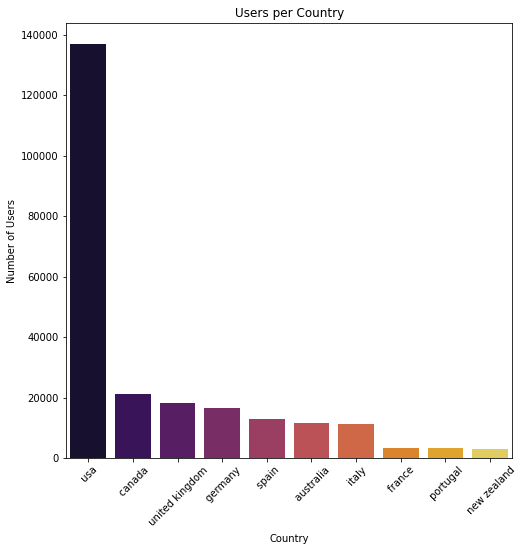

In [ ]:
##Counting Users per country.
f = Users.groupby(['Country'])['User-ID'].count().sort_values(ascending=False).head(10)
f = f.reset_index()

##Plotting the Top 10 Authors with most number of Books.
fig, ax = plt.subplots(figsize =(8,8))
c = sns.barplot(data=f, x='Country', y='User-ID', palette='inferno')
c.set(xlabel='Country', ylabel='Number of Users', title='Users per Country')
plt.xticks(rotation=45);

#### Most of the users are from the US.

## Summary Dataset

In [ ]:

r_cols = ['user_id','location','age', 'isbn', 'rating','book_title','book_author','year_of_publication','publisher','img_s','img_m','img_l','Summary','Language','Category', 'city', 'state', 'country']
Summary = pd.read_csv('/content/Books Data with Category Language and Summary/Preprocessed_data.csv', sep=',', names=r_cols, encoding='latin-1',low_memory=False)
Summary=Summary.iloc[1:,:]
Summary.head(5)

,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l,Summary,Language,Category,city,state,country
0.0,2,"stockton, california, usa",18.0,0195153448,0,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg,"Provides an introduction to classical myths placing the addressed\ntopics within their historical context, discussion of archaeological\nevidence as support for mythical events, and how these themes have\nbeen portrayed in literature, art, ...",en,['Social Science'],stockton,california,usa
1.0,8,"timmins, ontario, canada",34.74389988072476,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,"In a small town in Canada, Clara Callan reluctantly takes leave of her\nsister, Nora, who is bound for New York.",en,['Actresses'],timmins,ontario,canada
2.0,11400,"ottawa, ontario, canada",49.0,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,"In a small town in Canada, Clara Callan reluctantly takes leave of her\nsister, Nora, who is bound for New York.",en,['Actresses'],ottawa,ontario,canada
3.0,11676,"n/a, n/a, n/a",34.74389988072476,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,"In a small town in Canada, Clara Callan reluctantly takes leave of her\nsister, Nora, who is bound for New York.",en,['Actresses'],NaN,NaN,NaN
4.0,41385,"sudbury, ontario, canada",34.74389988072476,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,"In a small town in Canada, Clara Callan reluctantly takes leave of her\nsister, Nora, who is bound for New York.",en,['Actresses'],sudbury,ontario,canada


In [ ]:
##Dropping columns
Summary = Summary.drop(['location', 'age', 'img_s', 'img_m', 'city', 'state', 'country'], axis=1)
Summary.head(5)

,user_id,isbn,rating,book_title,book_author,year_of_publication,publisher,img_l,Summary,Language,Category
0.0,2,0195153448,0,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg,"Provides an introduction to classical myths placing the addressed\ntopics within their historical context, discussion of archaeological\nevidence as support for mythical events, and how these themes have\nbeen portrayed in literature, art, ...",en,['Social Science']
1.0,8,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,"In a small town in Canada, Clara Callan reluctantly takes leave of her\nsister, Nora, who is bound for New York.",en,['Actresses']
2.0,11400,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,"In a small town in Canada, Clara Callan reluctantly takes leave of her\nsister, Nora, who is bound for New York.",en,['Actresses']
3.0,11676,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,"In a small town in Canada, Clara Callan reluctantly takes leave of her\nsister, Nora, who is bound for New York.",en,['Actresses']
4.0,41385,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,"In a small town in Canada, Clara Callan reluctantly takes leave of her\nsister, Nora, who is bound for New York.",en,['Actresses']


In [ ]:
##Renaming columns to maintain uniformnity.
Summary = Summary.rename(columns = {'user_id': 'User-ID',
                                    'isbn': 'ISBN',
                                    'rating': 'Book-Rating',
                                    'book_title': 'Book-Title',
                                    'book_author': 'Book-Author',
                                    'year_of_publication': 'Year_Of_Publication',
                                    'publisher': 'Publisher',
                                    'img_l': 'Image-URL-L'})


In [ ]:
# Removing square brackets and quotes from Country column
Summary['Category'] = Summary['Category'].str.strip('[]').astype(str)
Summary['Category'] = Summary['Category'].str.strip("''").astype(str)
Summary.head(5)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year_Of_Publication,Publisher,Image-URL-L,Summary,Language,Category
0.0,2,0195153448,0,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg,"Provides an introduction to classical myths placing the addressed\ntopics within their historical context, discussion of archaeological\nevidence as support for mythical events, and how these themes have\nbeen portrayed in literature, art, ...",en,Social Science
1.0,8,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,"In a small town in Canada, Clara Callan reluctantly takes leave of her\nsister, Nora, who is bound for New York.",en,Actresses
2.0,11400,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,"In a small town in Canada, Clara Callan reluctantly takes leave of her\nsister, Nora, who is bound for New York.",en,Actresses
3.0,11676,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,"In a small town in Canada, Clara Callan reluctantly takes leave of her\nsister, Nora, who is bound for New York.",en,Actresses
4.0,41385,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,"In a small town in Canada, Clara Callan reluctantly takes leave of her\nsister, Nora, who is bound for New York.",en,Actresses


In [ ]:
##Checking for missing values.
Summary.isna().sum()

User-ID                0
ISBN                   0
Book-Rating            0
Book-Title             0
Book-Author            0
Year_Of_Publication    0
Publisher              0
Image-URL-L            0
Summary                0
Language               0
Category               0
dtype: int64

In [ ]:
Summary.dtypes

User-ID                object
ISBN                   object
Book-Rating            object
Book-Title             object
Book-Author            object
Year_Of_Publication    object
Publisher              object
Image-URL-L            object
Summary                object
Language               object
Category               object
dtype: object

# Collaborative Filtering based Recommendation System

In [ ]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [ ]:
##Keeping users that have rated atleast 100 books and keeping books that have atleast 100 ratings.
counts1 = Ratings['User-ID'].value_counts()
Ratings = Ratings[Ratings['User-ID'].isin(counts1[counts1 >= 100].index)]
counts = Ratings['Book-Rating'].value_counts()
Ratings = Ratings[Ratings['Book-Rating'].isin(counts[counts >= 100].index)]

# Comparing performance of different Algorithms from Surprise package

In [ ]:
!pip install surprise
from collections import defaultdict
import surprise
from surprise.reader import Reader
from surprise import Dataset
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

from surprise import SVD
from surprise import NMF
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

In [ ]:
from surprise import Dataset
from surprise import Reader
from sklearn.model_selection import train_test_split
combined_book_data = pd.merge(Ratings, Books, on='ISBN')
combined_book_data=combined_book_data[['User-ID', 'ISBN','Book-Rating','Book-Title' ,'Book-Author','Year-Of-Publication', 'Publisher']]

combined_book_data['reviews'] = combined_book_data.groupby(['ISBN'])['Book-Rating'].transform('count')
combined_book_data= combined_book_data[combined_book_data.reviews>25][['User-ID', 'ISBN','Book-Rating']]



train1, test1 = train_test_split(Ratings, test_size=0.5,random_state=7, shuffle=True)
train2, test2 = train_test_split(Ratings, test_size=0.5,random_state=65, shuffle=True)
train3, test3 = train_test_split(Ratings, test_size=0.5,random_state=93, shuffle=True)
train4, test4 = train_test_split(Ratings, test_size=0.5,random_state=34, shuffle=True)
train5, test5 = train_test_split(Ratings, test_size=0.6,random_state=34, shuffle=True)
train6, test6 = train_test_split(Ratings, test_size=0.7,random_state=34, shuffle=True)
train7, test7 = train_test_split(Ratings, test_size=0.8,random_state=34, shuffle=True)
train8, test8 = train_test_split(Ratings, test_size=0.9,random_state=34, shuffle=True)

reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(Ratings[['User-ID', 'ISBN','Book-Rating']], reader)
data1 = Dataset.load_from_df(test1[['User-ID', 'ISBN','Book-Rating']], reader)
data2 = Dataset.load_from_df(test2[['User-ID', 'ISBN','Book-Rating']], reader)
data3 = Dataset.load_from_df(test3[['User-ID', 'ISBN','Book-Rating']], reader)
data4= Dataset.load_from_df(test4[['User-ID', 'ISBN','Book-Rating']], reader)
data5= Dataset.load_from_df(test5[['User-ID', 'ISBN','Book-Rating']], reader)
data6= Dataset.load_from_df(test6[['User-ID', 'ISBN','Book-Rating']], reader)
data7= Dataset.load_from_df(test7[['User-ID', 'ISBN','Book-Rating']], reader)
data8= Dataset.load_from_df(test8[['User-ID', 'ISBN','Book-Rating']], reader)


## Testing SVD, KNNWithZScore, BaselineOnly, CoClustering algorithms on different samples but same data size

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Algorithm	 RMSE		 MAE

SVD 		 3.1938 	 2.5574
KNN ZScore 	 3.5919 	 2.9567
Baselineonly  	 3.199 	 2.5863
CoClustering 	 3.7468 	 3.0672


 Random Sample  1


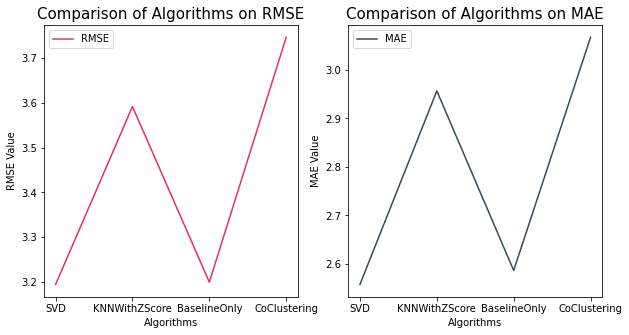

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Algorithm	 RMSE		 MAE

SVD 		 3.1869 	 2.5482
KNN ZScore 	 3.6197 	 2.9414
Baselineonly  	 3.1804 	 2.5619
CoClustering 	 3.7075 	 3.0132


 Random Sample  2


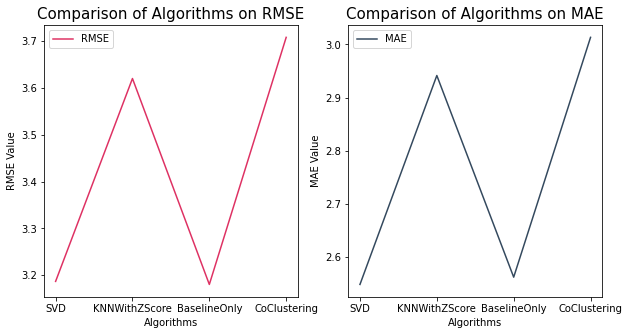

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Algorithm	 RMSE		 MAE

SVD 		 3.1902 	 2.5497
KNN ZScore 	 3.6372 	 2.9311
Baselineonly  	 3.1694 	 2.5473
CoClustering 	 3.704 	 3.0008


 Random Sample  3


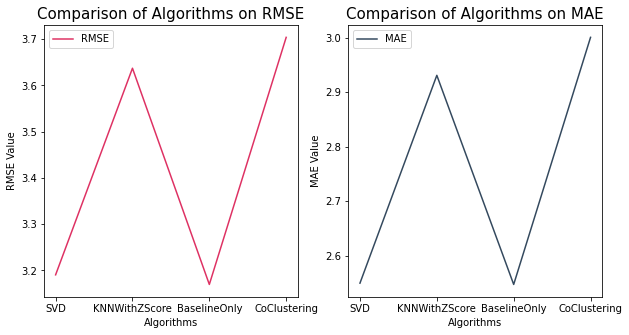

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Algorithm	 RMSE		 MAE

SVD 		 3.1889 	 2.5457
KNN ZScore 	 3.6393 	 2.9137
Baselineonly  	 3.1607 	 2.5378
CoClustering 	 3.6843 	 2.9718


 Random Sample  4


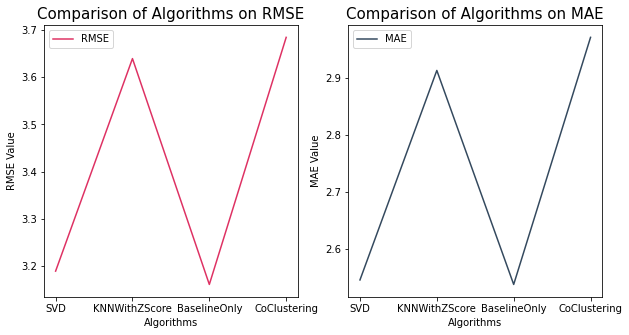

In [ ]:
from surprise import SVD, SVDpp, NMF
from surprise import SlopeOne, CoClustering,KNNWithZScore, BaselineOnly,KNNBaseline
algorithms=['SVD','KNNWithZScore' , 'BaselineOnly' , 'CoClustering']
SVD_params=[]
KNNWithZScore_params=[]
Baseonly_params=[]
NMF_params=[]
dataset=[data1,data2,data3,data4]
count=0
for dt in dataset:
    count=count+1
    SVD_params=cross_validate(SVD(), dt, cv=2, verbose=False)  
    KNNWithZScore_params=cross_validate(KNNWithZScore(), dt, cv=2, verbose=False)
    Baseonly_params=cross_validate(BaselineOnly(), dt, cv=2, verbose=False)
    CoClustering_params=cross_validate(CoClustering(), dt, cv=2, verbose=False)
    algorithms=['SVD','KNNWithZScore' , 'Baseonly' , 'CoClustering']
    print('Algorithm\t RMSE\t\t MAE')
    print()
    print('SVD', '\t', round(SVD_params['test_rmse'].mean(), 4), '\t', round(SVD_params['test_mae'].mean(), 4))
    print('KNN ZScore', '\t', round(KNNWithZScore_params['test_rmse'].mean(), 4), '\t', round(KNNWithZScore_params['test_mae'].mean(), 4))
    print('Baselineonly ', '\t', round(Baseonly_params['test_rmse'].mean(), 4), '\t', round(Baseonly_params['test_mae'].mean(), 4))
    print('CoClustering', '\t', round(CoClustering_params['test_rmse'].mean(), 4), '\t', round(CoClustering_params['test_mae'].mean(), 4))
    algorithms=['SVD','KNNWithZScore' , 'BaselineOnly' , 'CoClustering']
    algo_stats=[SVD_params,KNNWithZScore_params,Baseonly_params,CoClustering_params]
    print("\n\n Random Sample ",count)
    rmse_cv = [round(i['test_rmse'].mean(), 4) for i in algo_stats]
    mae_cv = [round(i['test_mae'].mean(), 4) for i in algo_stats]

    plt.figure(figsize=(10,5))

    plt.subplot(1, 2, 1)
    plt.title('Comparison of Algorithms on RMSE', loc='center', fontsize=15)
    plt.plot(algorithms, rmse_cv, label='RMSE', color='#DE3163')
    plt.xlabel('Algorithms')
    plt.ylabel('RMSE Value')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title('Comparison of Algorithms on MAE', loc='center', fontsize=15)
    plt.plot(algorithms, mae_cv, label='MAE', color='#34495E')
    plt.xlabel('Algorithms')
    plt.ylabel('MAE Value')
    plt.legend()

    plt.show()

## Testing SVD, KNNWithZScore, BaselineOnly, CoClustering algorithms on different data size

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Algorithm	 RMSE		 MAE

SVD 		 3.1906 	 2.547
KNN ZScore 	 3.6415 	 2.9131
Baselineonly  	 3.162 	 2.5371
CoClustering 	 3.7009 	 2.9794


 Sample size  1


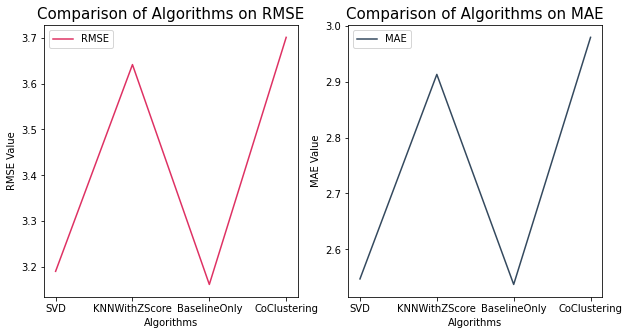

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Algorithm	 RMSE		 MAE

SVD 		 3.1969 	 2.5518
KNN ZScore 	 3.6344 	 2.8957
Baselineonly  	 3.1563 	 2.5313
CoClustering 	 3.6657 	 2.9531


 Sample size  2


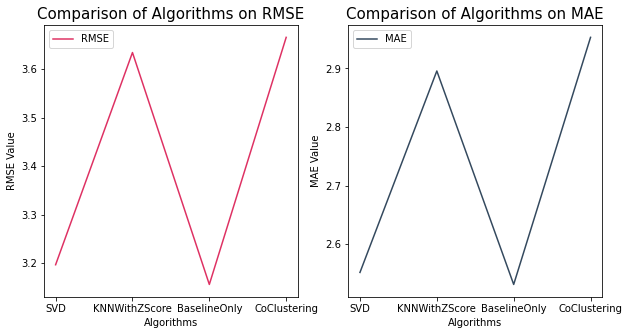

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Algorithm	 RMSE		 MAE

SVD 		 3.2037 	 2.5569
KNN ZScore 	 3.6344 	 2.8866
Baselineonly  	 3.1535 	 2.5279
CoClustering 	 3.6677 	 2.9342


 Sample size  3


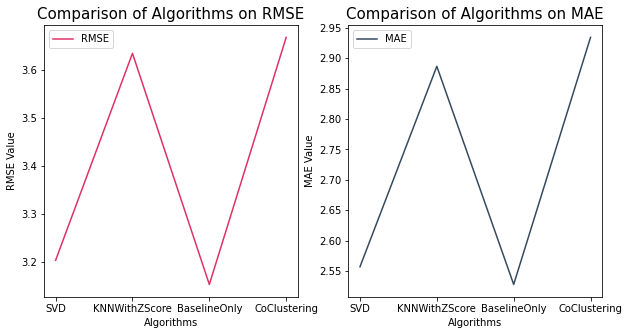

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Algorithm	 RMSE		 MAE

SVD 		 3.2065 	 2.5576
KNN ZScore 	 3.6284 	 2.8756
Baselineonly  	 3.1499 	 2.5241
CoClustering 	 3.6559 	 2.9269


 Sample size  4


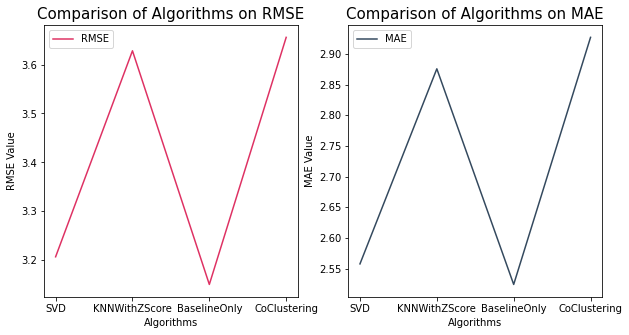

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Algorithm	 RMSE		 MAE

SVD 		 3.2059 	 2.5552
KNN ZScore 	 3.6123 	 2.8544
Baselineonly  	 3.1448 	 2.5167
CoClustering 	 3.6429 	 2.904


 Sample size  5


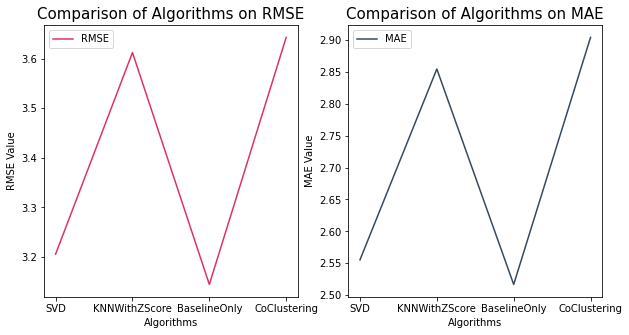

In [ ]:
from surprise import SVD, SVDpp, NMF
from surprise import SlopeOne, CoClustering,KNNWithZScore, BaselineOnly,KNNBaseline
algorithms=['SVD','KNNWithZScore' , 'BaselineOnly' , 'CoClustering']
SVD_params=[]
KNNWithZScore_params=[]
Baseonly_params=[]
NMF_params=[]
dataset=[data4,data5,data6,data7,data8]
count=0
for dt in dataset:
    count=count+1
    SVD_params=cross_validate(SVD(), dt, cv=2, verbose=False)  
    KNNWithZScore_params=cross_validate(KNNWithZScore(), dt, cv=2, verbose=False)
    Baseonly_params=cross_validate(BaselineOnly(), dt, cv=2, verbose=False)
    CoClustering_params=cross_validate(CoClustering(), dt, cv=2, verbose=False)
    algorithms=['SVD','KNNWithZScore' , 'Baseonly' , 'CoClustering']
    print('Algorithm\t RMSE\t\t MAE')
    print()
    print('SVD', '\t\t', round(SVD_params['test_rmse'].mean(), 4), '\t', round(SVD_params['test_mae'].mean(), 4))
    print('KNN ZScore', '\t', round(KNNWithZScore_params['test_rmse'].mean(), 4), '\t', round(KNNWithZScore_params['test_mae'].mean(), 4))
    print('Baselineonly ', '\t', round(Baseonly_params['test_rmse'].mean(), 4), '\t', round(Baseonly_params['test_mae'].mean(), 4))
    print('CoClustering', '\t', round(CoClustering_params['test_rmse'].mean(), 4), '\t', round(CoClustering_params['test_mae'].mean(), 4))
    algorithms=['SVD','KNNWithZScore' , 'BaselineOnly' , 'CoClustering']
    algo_stats=[SVD_params,KNNWithZScore_params,Baseonly_params,CoClustering_params]
    print("\n\n Sample size ",count)
    rmse_cv = [round(i['test_rmse'].mean(), 4) for i in algo_stats]
    mae_cv = [round(i['test_mae'].mean(), 4) for i in algo_stats]

    plt.figure(figsize=(10,5))

    plt.subplot(1, 2, 1)
    plt.title('Comparison of Algorithms on RMSE', loc='center', fontsize=15)
    plt.plot(algorithms, rmse_cv, label='RMSE', color='#DE3163')
    plt.xlabel('Algorithms')
    plt.ylabel('RMSE Value')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title('Comparison of Algorithms on MAE', loc='center', fontsize=15)
    plt.plot(algorithms, mae_cv, label='MAE', color='#34495E')
    plt.xlabel('Algorithms')
    plt.ylabel('MAE Value')
    plt.legend()

    plt.show()

## Conclusion : 
1. Performance of SVD worsen increasing the datset
2. KNN with Z score performes better when the dataset increases but the rate is very slow as compared to BaselineOnly
3. Baseline Only performes better when the dataset increases.
4. CoClustering also performes better when the dataset increases but the rate is very slow as compared to BaselineOnly

# Recommendation using Suprise (SVD Algorithm)

### Cross Validation for SVD

In [ ]:
from surprise import SVD
from surprise.model_selection import cross_validate

svd = SVD(verbose=True, n_epochs=10)
svd_params=cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=2, verbose=True)


In [ ]:
trainset = data.build_full_trainset()
svd.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9


In [ ]:
import difflib
import random

def get_book_isbn(book_title, metadata):
    
    existing_titles = list(metadata['Book-Title'].values)
    closest_titles = difflib.get_close_matches(book_title, existing_titles)
    book_id = metadata[metadata['Book-Title'] == closest_titles[0]]['ISBN'].values[0]
    return book_id

def get_book_info(book_id, metadata):
    
    book_info = metadata[metadata['ISBN'] == book_id][['ISBN', 'Book-Title', 
                                                    'Book-Author','Year-Of-Publication', 'Publisher','Image-URL-S','Image-URL-M','Image-URL-L']]
                                                    
    return book_info.to_dict(orient='records')

def predict_review(user_id, book_title, model, metadata):
    
    book_id = get_book_isbn(book_title, metadata)
    review_prediction = model.predict(uid=user_id, iid=book_id)
    return review_prediction.est

def generate_recommendation(user_id, model, metadata, thresh=4):
    
    book_titles = list(metadata['Book-Title'].values)
    random.shuffle(book_titles)
    
    for book_title in book_titles:
        rating = predict_review(user_id, book_title, model, metadata)
        if rating >= thresh:
            book_id = get_book_isbn(book_title, metadata)
            return get_book_info(book_id, metadata)

In [ ]:
User_rec='276729'
Recommended_Book=generate_recommendation(User_rec, svd, Books)


The Book recommendation for user with User ID  276729 : 

Name -  Prime Time Together With Kids: Creative Ideas, Activities, Games, and Projects 
Author -  Donna Erickson
ISBN -  0806624302
Publisher -  Augsburg Fortress Publishers 


AxesImage(54,36;334.8x217.44)


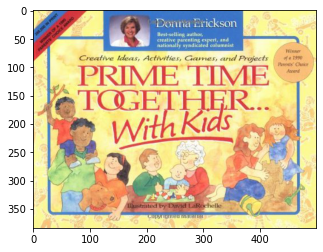

In [ ]:
print("The Book recommendation for user with User ID ",User_rec,": \n\nName - ",Recommended_Book[0]['Book-Title'],"\nAuthor - ",Recommended_Book[0]['Book-Author'])
print("ISBN - ",Recommended_Book[0]['ISBN'])
print("Publisher - ",Recommended_Book[0]['Publisher'],"\n\n")

response = requests.get(Recommended_Book[0]['Image-URL-L']);
img = Image.open(BytesIO(response.content));
plt.figure();
print(plt.imshow(img));

# Recommendation based on SVD Algorithms

In [ ]:
from sklearn.model_selection import train_test_split
import scipy.sparse as sparse
from sklearn.preprocessing import LabelEncoder

# Using Label encoder converting columns User-ID, Book-Rating into numerica values to perform SVD and K means 

#
counts1 = Ratings['User-ID'].value_counts()
Summary = Summary[Summary['User-ID'].isin(counts1[counts1 >= 500].index)]
counts = Ratings['Book-Rating'].value_counts()
Summary = Summary[Summary['Book-Rating'].isin(counts[counts >= 500].index)]


Summary= Summary.drop_duplicates(['User-ID','Book-Title'])
Summary= Summary.drop_duplicates(['User-ID','ISBN'])
Summary_svd=Summary.copy()
train, test = train_test_split(Summary_svd, test_size=0.9,random_state=7, shuffle=True)
enc = LabelEncoder()
enc.fit(train['ISBN'])

train['ISBN'] = enc.transform(train['ISBN'])
enc = LabelEncoder()
enc.fit(Summary_svd['User-ID'])
train['User-ID'] = enc.transform(train['User-ID'])
train['Book-Rating'] = train['Book-Rating'].astype(float)

train.shape 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

(31342, 11)

In [ ]:
train

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year_Of_Publication,Publisher,Image-URL-L,Summary,Language,Category
994227.0,135,24412,0.0,"365 Quick, Easy & Inexpensive Dinner Menus",Penny E. Stone,1999.0,Champion Press Ltd,http://images.amazon.com/images/P/1891400339.01.LZZZZZZZ.jpg,"With homespun charm, warm wit and playful trivia, home-cooks are\nprovided with a ready-made plan for entire meals that are fun,\neconomical and easy. 365 Quick, Easy and Inexpensive Dinner Menus is a\ncookbook for the entire family, and its ...",en,Cooking
671534.0,76,5617,0.0,"Rain Dance (Wwl Mystery , No 278)",Skye Kathleen Moody,1998.0,Worldwide Library,http://images.amazon.com/images/P/0373262787.01.LZZZZZZZ.jpg,9,9,9
116782.0,125,11072,0.0,1st to Die: A Novel,James Patterson,2002.0,Warner Vision,http://images.amazon.com/images/P/0446610038.01.LZZZZZZZ.jpg,"Full of the breathtaking drama and unforgettable emotions for which\nJames Patterson is famous, 1st to Die is the start of the #1 New York\nTimes bestselling series of crime thrillers.",en,Fiction
760296.0,246,17683,0.0,The Curse of the Calico Cat (Stepping Stone Books),Ellen Weiss,1994.0,Random House Children's Books,http://images.amazon.com/images/P/0679854053.01.LZZZZZZZ.jpg,Nonnie and her Uncle Paul help her new friends get rid of the evil cat\nwhich came along with their ancient family curse.,en,Blessing and cursing
138550.0,114,7780,0.0,The Book of Ruth (Oprah's Book Club (Paperback)),Jane Hamilton,1990.0,Anchor,http://images.amazon.com/images/P/0385265700.01.LZZZZZZZ.jpg,"Ruth tries to hold her own in a small town where she can&#39;t escape\npoverty and hard knocks. When the household erupts in violence, Ruth\nis the only one who can piece the story together.",en,Middle West
...,...,...,...,...,...,...,...,...,...,...,...
809547.0,267,280,0.0,Behindlings: A Novel,Nicola Barker,2003.0,Ecco,http://images.amazon.com/images/P/0060185694.01.LZZZZZZZ.jpg,9,9,9
56887.0,208,2339,0.0,101 Dalmatians,Justine Korman,1996.0,Golden Books Publishing Company,http://images.amazon.com/images/P/0307001164.01.LZZZZZZZ.jpg,9,9,9
224917.0,89,11824,0.0,Lie Down With Lions,Ken Follett,1986.0,New Amer Library (Mm),http://images.amazon.com/images/P/0451146425.01.LZZZZZZZ.jpg,"Ellis, the American.",en,Fiction
675367.0,223,14898,0.0,Babylon Rising (Babylon Rising (Paperback)),TIM LAHAYE,2004.0,Dell,http://images.amazon.com/images/P/0553586068.01.LZZZZZZZ.jpg,"A dramatic discovery sends Michael Murphy, a field archaeologist and\nscholar of biblical prophecy, on a perilous quest away from his secure\nworld to a deadly confrontation with the forces of evil. Reprint.",en,Fiction


In [ ]:
books_matrix = train.pivot_table(index = 'User-ID', columns = 'Book-Title', values = 'Book-Rating').fillna(0)
books_matrix.shape
books_matrix.head()

Book-Title,"Good Wives: Image and Reality in the Lives of Women in Northern New England, 1650-1750",Hiking the California Coastal Trail: Oregon to Monterey,"Little Comic Shop of Horrors (Give Yourself Goosebumps, Book 17)",Murder of a Sleeping Beauty (Scumble River Mysteries (Paperback)),"Q-Space (Star Trek The Next Generation, Book 47)","Q-Zone (Star Trek The Next Generation, Book 48)","Zap!: Science Fair Surprise! (Abracadabra!, Book 5)",'A Hell of a Place to Lose a Cow': An American Hitchhiking Odyssey,'Salem's Lot,'Tis The Season (Christmas Anthology): Under the Mistletoe/A Baby for Christmas/Christmas Angel/Home for Christmas,"'Tis The Season (Harlequin Temptation, No 278)",--y los 40 ladrones (ColecciÃÂ³n FÃÂ¡bula),0373953194 Christmas Stories 1993,09/11 8:48 am: Documenting America's Greatest Tragedy,1 RAGGED RIDGE ROAD,"1,000 Places to See Before You Die","1,000,001 Things That Make You Crabby: The Official Checklist for Complainers, Ranters, Ravers and Bellyachers, and Everybody Else","1,001 Old-Time Garden Tips: Timeless Bits of Wisdom on How to Grow Everything Organically, from the Good Old Days When Everyone Did","1,003 Great Things About Kids",10 Lb. Penalty,10 Minute Guide to Excel 97 (10 Minute Guides (Computer Books)),10 Natural Laws of Successful Time and Life Management,10 Years of Matt,"10,000 Dreams Interpreted or What's in a Dream",100 Best-Loved Poems (Dover Thrift Editions),100 Greatest Women,100 Malicious Little Mysteries,100 Selected Poems by E. E. Cummings,100 Weekend Cross-Stitch Gifts,1000 Jokes for Kids of All Ages,1001 More Ways to Be Romantic,1001 Things Everyone Should Know About Science,101 Back to School Jokes,101 Dalmatians,101 Dalmatians : Escape from De Vil Mansion,101 Most Powerful Verses in the Bible,101 Nutty Nature Jokes,101 Outer Space Jokes (101 Joke Book),101 Pet Jokes,101 Promises Worth Keeping (For Men Only),...,Zhou Enlai and the XiÃÂ®an incident: An eyewitness account : a turning point in Chinese history,ZigZag: A Novel,"Ziggy Faces Life, Again!",Zimmermann Telegram,"Zinn and the Art of Mountain Bike Maintenance, Third Edition",Zits-Sketchbook #1,Zodiac,Zodiac: The Eco-Thriller,Zoe's Snowy Day (Cartwheel),Zombie,Zombies of the Gene Pool,Zone: A Dietary Road Map to Lose Weight Permanently,Zoos (New True Book),Zorba the Hutt's Revenge (Star Wars (Random House Paperback)),Zoya,Zukunftsmarkt Business on Demand. Unternehmenserfolg durch stÃ?ÃÂ¤ndige VerfÃ?ÃÂ¼gbarkeit.,Zum Leben erweckt.,"\ Lamb to the Slaughter and Other Stories (Penguin 60s S.)""","\B\"" Is for Betsy (Odyssey Classic)""","\B\"" is for burglar (A Kinsey Millhone mystery)""","\Dear Gangster...\"": Advice for the Lonelyhearted from the Gangster of Love""","\Everyday Use\"" (Women writers)""","\Girls' Night Out\""/\""Boys' Night In\""""","\God's Grandeur\"" and Other Poems (Dover Thrift Editions)""","\Good Housekeeping\"" Creative Cookery (Good Housekeeping)""","\Not Now!\"" Said the Cow (Bank Street Ready-to-Read/Level 2)""","\O\"" Is for Outlaw""","\Surely You're Joking, Mr. Feynman!\"": Adventures of a Curious Character""","\The Little Regiment\"" and Other Civil War Stories (Dover Thrift Editions)""","\The Yellow Wallpaper\"" and Other Stories (Penguin Classics 60s)""","\To His Coy Mistress\"" and Other Poems (Dover Thrift Editions)""","\What Do You Care What Other People Think?\"": Further Adventures of a Curious Character""","\Where Are You Going, Where Have You Been?\"" (Women Writers : Texts and Contexts)""",e,my three girls (count on a cop),seaQuest 2,sed & awk (2nd Edition),stardust,together by christmas,Ã?Ã?ber die Pflicht zum Ungehorsam gegen den Staat.
User-ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [ ]:
from sklearn.decomposition import TruncatedSVD
X = books_matrix.values.T
X.shape
#Fitting the Model
SVD = TruncatedSVD(n_components=12, random_state=0)
matrix = SVD.fit_transform(X)
matrix.shape

(23798, 12)

In [ ]:
import numpy as np

corr = np.corrcoef(matrix)
corr.shape

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


(23798, 23798)

In [ ]:
title = books_matrix.columns
title_list = list(title)
samia = title_list.index('The Notebook')
corr_samia  = corr[samia]
print(" Top 10 Book recommendations are :")
list(title[(corr_samia >= 0.99)])[:10]

 Top 10 Book recommendations are :


['A Barefoot Doctors Manual: The American Translation of the Official Chinese Paramedical Manual',
 'A Darkness More Than Night',
 'A Z Aromatherapy',
 'Agatha Raisin and the Wellspring of Death (An Agatha Raisin Mystery)',
 'And Then You Die',
 'Angels (Postbox Collection)',
 'Baby',
 'Bare Necessity',
 'Better Homes and Gardens Bread Machine Bounty',
 'Compelling Evidence']

# K-means Clustering on basis of Book Genre and average rating given to that book

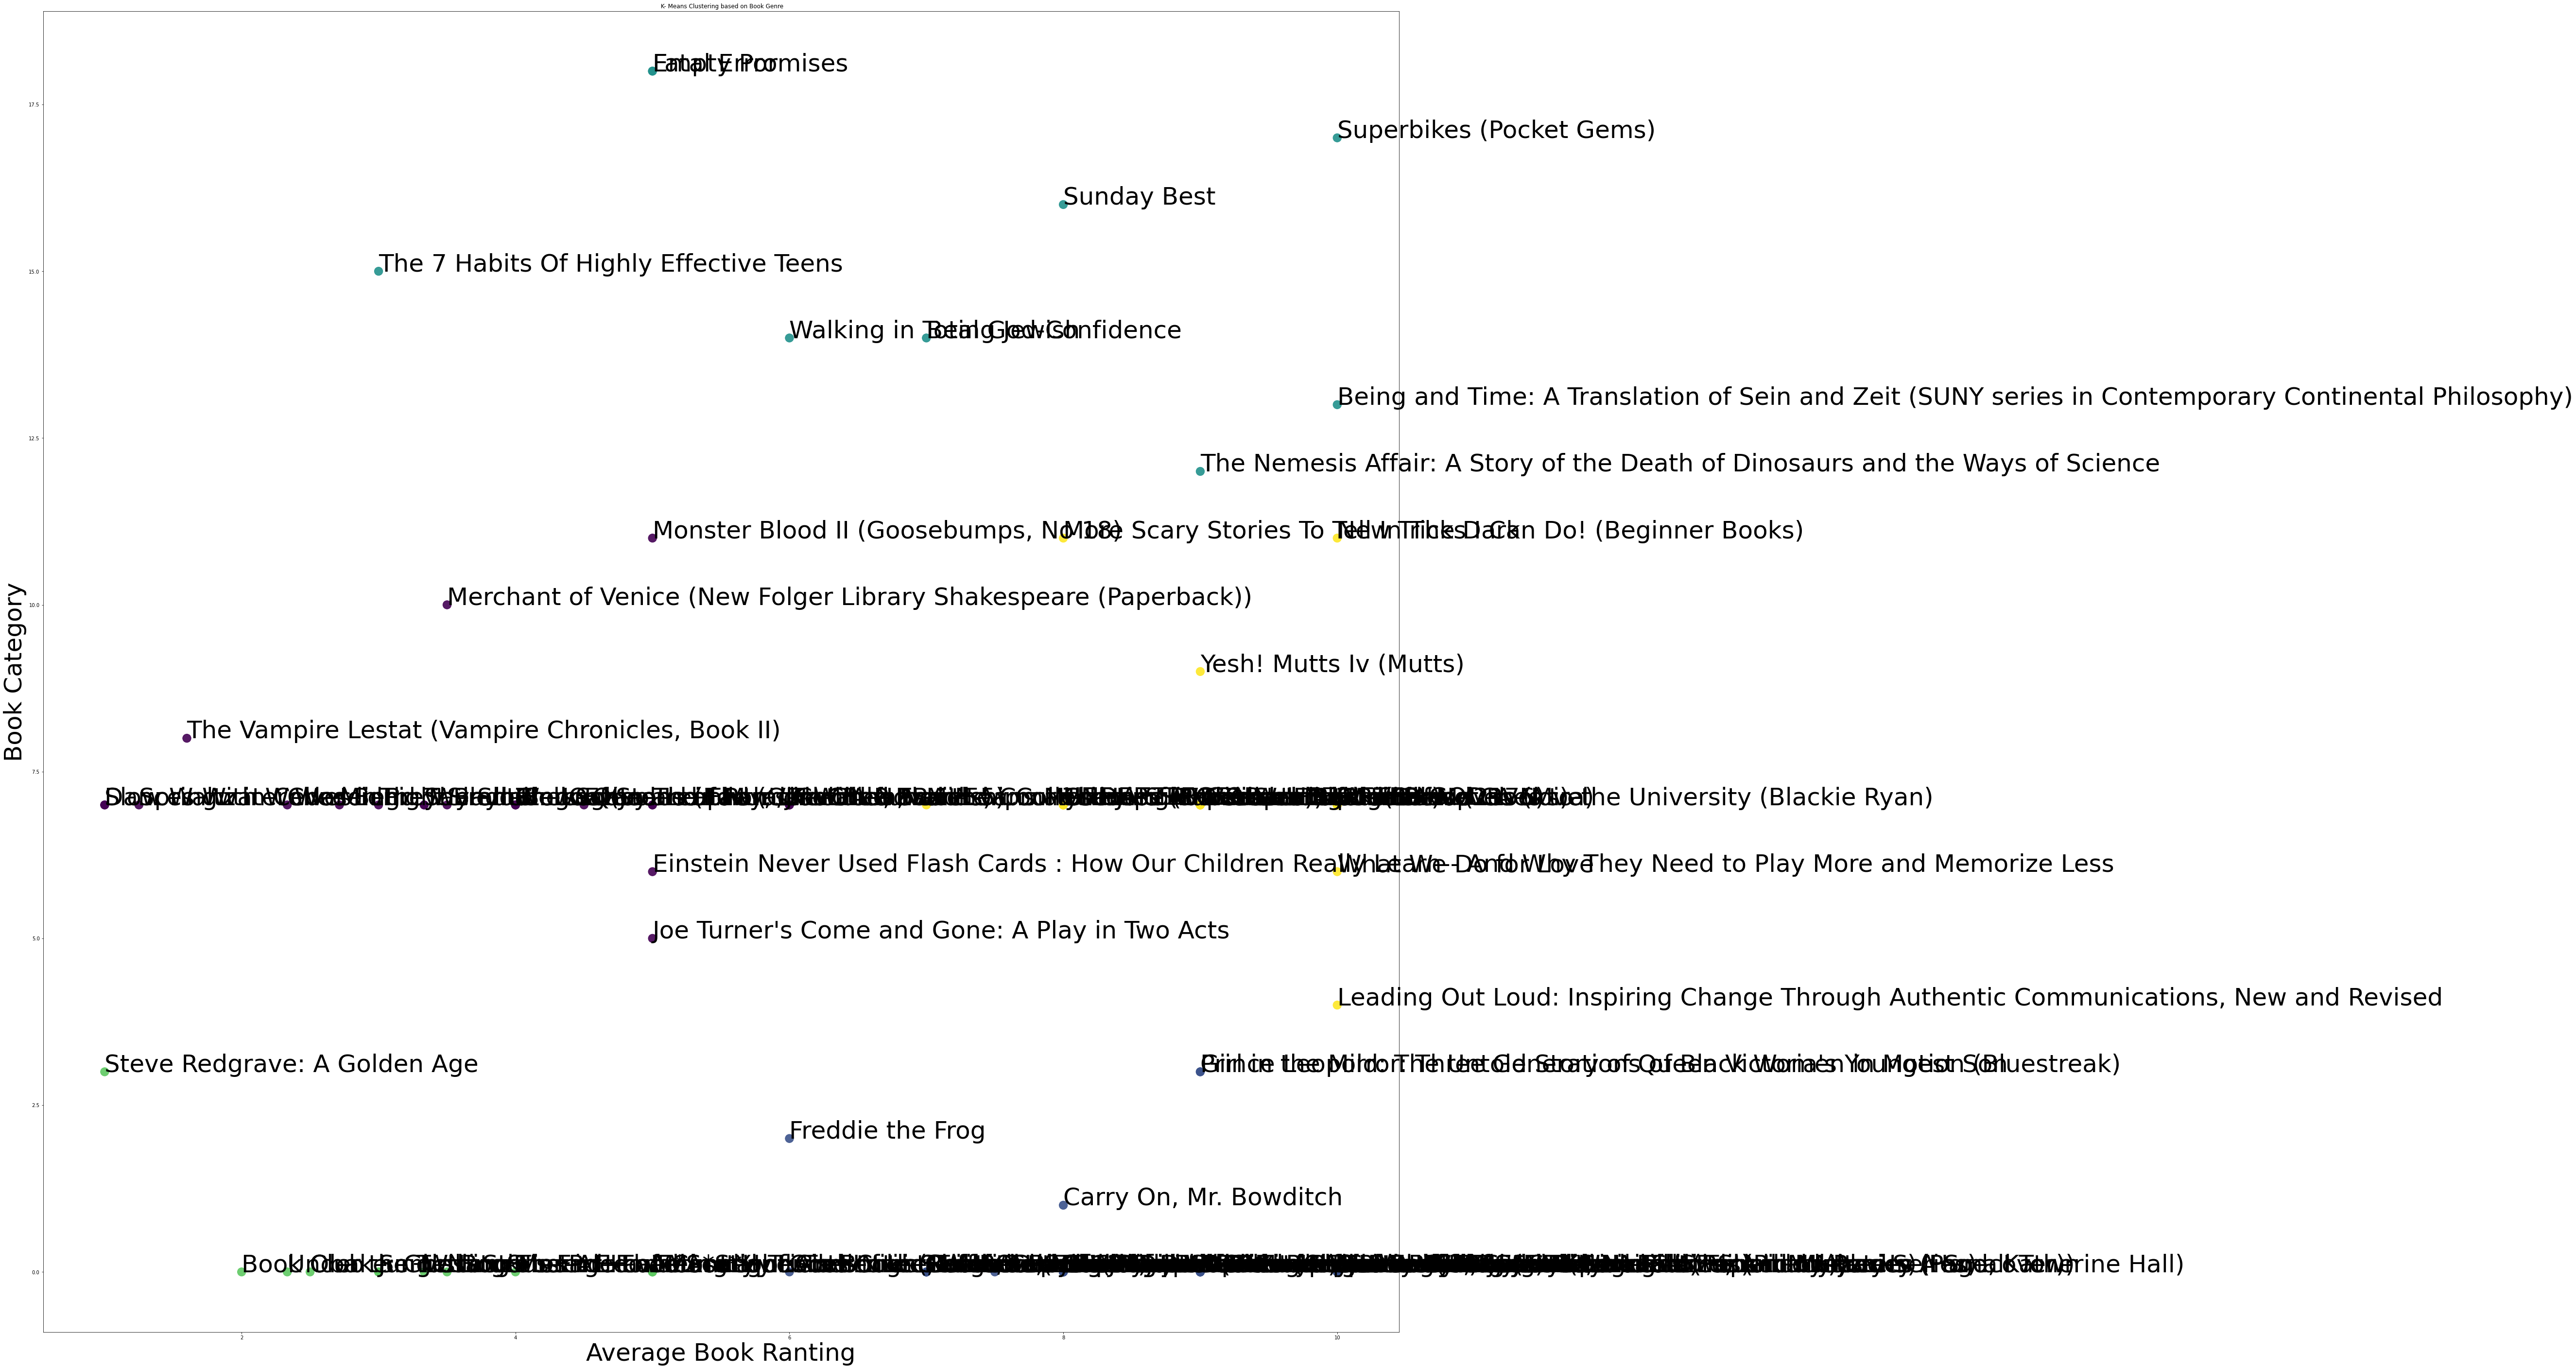

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

kmeans_df=train[['Category','Book-Rating','Book-Title']]
kmeans_df=kmeans_df.groupby(['Category','Book-Title'], as_index=False)['Book-Rating'].mean()
kmeans_df=kmeans_df[kmeans_df['Book-Rating']!=0.0]

#kmeans_df['Book-Title'] = kmeans_df['Book-Title'].astype('str')
#mask = (kmeans_df['Book-Title'].str.len() <= 20)
#kmeans_df = kmeans_df.loc[mask]
kmeans_df=kmeans_df.sample(n=100) #Randomly selecting 100 books
#kmeans_df['Book-Title'] = kmeans_df['Book-Title'].str.slice(0, 20)
enc = LabelEncoder()
enc.fit(kmeans_df['Category'])
kmeans_df['Category'] = enc.transform(kmeans_df['Category'])
kmeans_df2=kmeans_df[['Category','Book-Rating']]
kmeans = KMeans(n_clusters=5).fit(kmeans_df2)

plt.figure(figsize=(50, 50))
plt.xlabel("Average Book Ranting",fontsize=50)
plt.ylabel("Book Category",fontsize=50)
plt.title(" K- Means Clustering based on Book Genre")
annotations=kmeans_df['Book-Title'].to_numpy() 
plt.scatter( kmeans_df2['Book-Rating'],kmeans_df2['Category'], c= kmeans.labels_.astype(float), s=300, alpha=0.9)
for i, label in enumerate(annotations):
    plt.annotate(label, ( kmeans_df2['Book-Rating'].iloc[i],kmeans_df2['Category'].iloc[i]), fontsize=50)
plt.show()

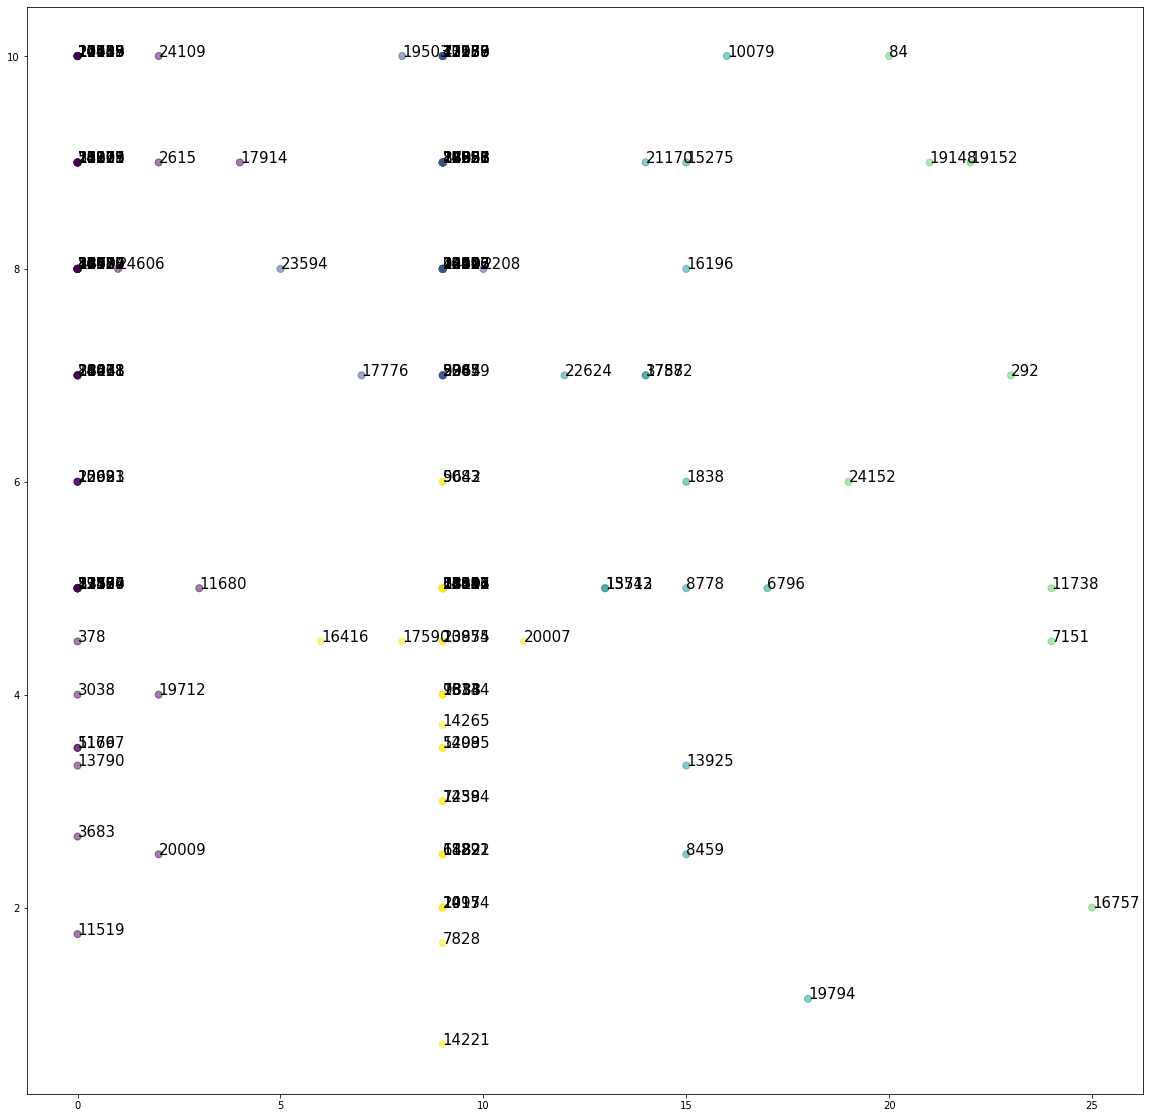

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

kmeans_df=train[['Category','Book-Rating','ISBN']]
kmeans_df=kmeans_df.groupby(['Category','ISBN'], as_index=False)['Book-Rating'].mean()
kmeans_df=kmeans_df[kmeans_df['Book-Rating']!=0.0]
#kmeans_df['Book-Title'] = kmeans_df['Book-Title'].astype('str')
#mask = (kmeans_df['Book-Title'].str.len() <= 20)
#kmeans_df = kmeans_df.loc[mask]

#kmeans_df=kmeans_df[kmeans_df['Book-Rating']>9] #Selecting top rated books
kmeans_df=kmeans_df.sample(n=150) #Randomly selecting 150 books
enc = LabelEncoder()
enc.fit(kmeans_df['Category'])
kmeans_df['Category'] = enc.transform(kmeans_df['Category'])
kmeans_df2=kmeans_df[['Category','Book-Rating']]
kmeans = KMeans(n_clusters=5).fit(kmeans_df2)
centroids = kmeans.cluster_centers_

plt.figure(figsize=(20, 20))
annotations=kmeans_df['ISBN'].to_numpy() 
plt.scatter(kmeans_df2['Category'], kmeans_df2['Book-Rating'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
for i, label in enumerate(annotations):
    plt.annotate(label, (kmeans_df2['Category'].iloc[i], kmeans_df2['Book-Rating'].iloc[i]), fontsize=15)
#plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()